In [2396]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter

# Preprocessing the testing and training data

### Load Data

In [2397]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
IDtest = test["PassengerId"]

In [2398]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2399]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Detect Outliers

In [2400]:
def find_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    
    Note: This definition code is from a Github repository
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # find list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    final_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return final_outliers   


In [2401]:
# Find any outliers in Age, SibSp, Parch and Fare
drop_outliers = find_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [2402]:
# Display the outliers found
train.loc[drop_outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [2403]:
# Drop the outliers
train = train.drop(drop_outliers, axis = 0).reset_index(drop=True)

In [2404]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### Detect null and missing values

In [2405]:
train = train.fillna(np.nan)
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     881 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         0
dtype: int64

In [2406]:
test = test.fillna(np.nan)
test.info()
test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

### Final preprocessed training data

In [2407]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2408]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [2409]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# Feature Analysis

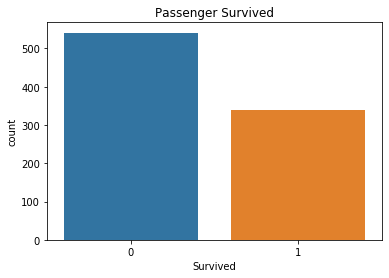

In [2410]:
# See how many people survived
fig, axs = plt.subplots()
sns.countplot(train['Survived'], ax=axs)
axs.set_title('Passenger Survived')
fig.savefig('./passenger_survived.png')
plt.show()

In [2411]:
# Only 38.59 percent survived
train[["Survived"]].mean()

Survived    0.385925
dtype: float64

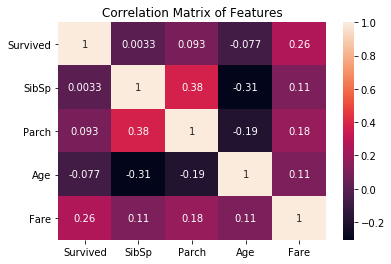

In [2412]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True).set_title('Correlation Matrix of Features')

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


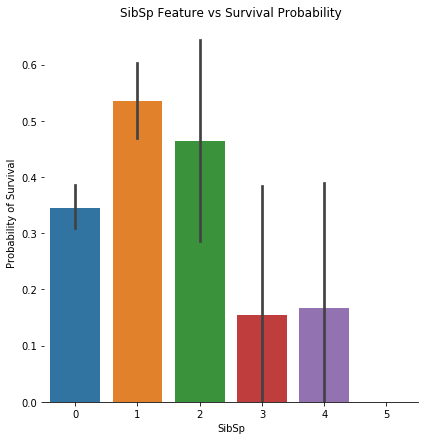

In [2413]:
# Explore SibSp (or number of siblings/spouses aboard) feature vs Survived
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size = 6).set(title='SibSp Feature vs Survival Probability')
g.despine(left=True)
g = g.set_ylabels("Probability of Survival")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


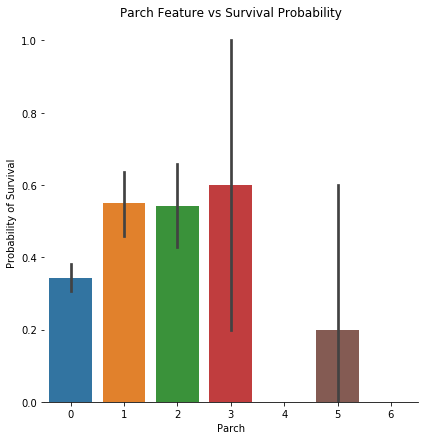

In [2414]:
# Explore Parch (or number of parents/children aboard) feature vs Survived
g = sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size = 6).set(title='Parch Feature vs Survival Probability')
g.despine(left=True)
g = g.set_ylabels("Probability of Survival")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


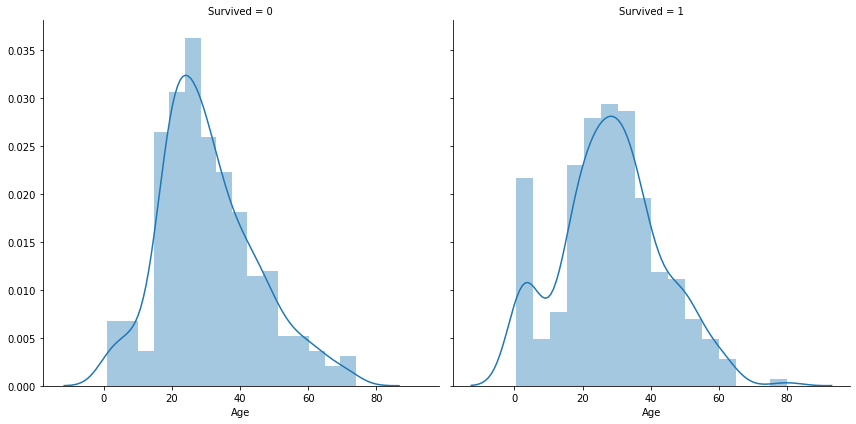

In [2415]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived', size = 6).set(title='Age Feature and Survival')
g = g.map(sns.distplot, "Age")

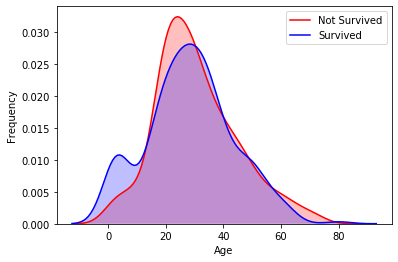

In [2416]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])


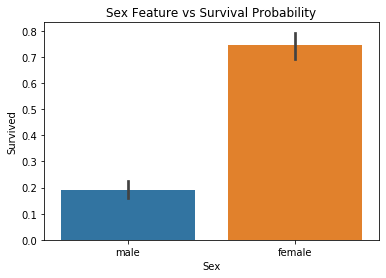

In [2417]:
# Explore Sex Feature vs Survival
g = sns.barplot(x="Sex",y="Survived",data=train).set(title='Sex Feature vs Survival Probability')


In [2418]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


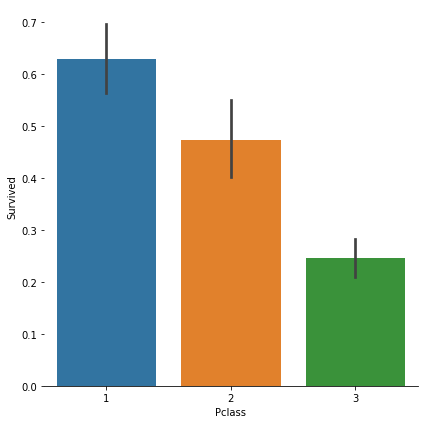

In [2419]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 )
g.despine(left=True)


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


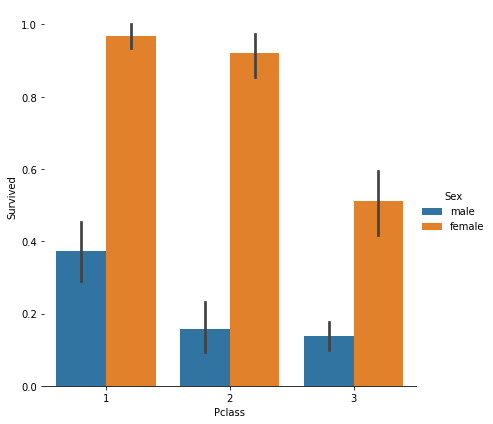

In [2420]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train, size=6, kind="bar")
g.despine(left=True)


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


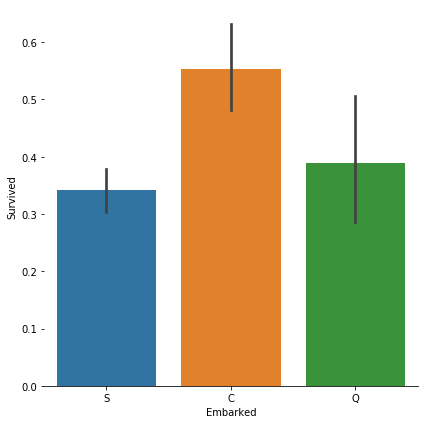

In [2421]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train, size=6, kind="bar")
g.despine(left=True)


# Filling Missing Values and Converting to Int

#### Sex

In [2422]:
# convert Sex into categorical value 0 for male and 1 for female
train["Sex"] = train["Sex"].map({"male": 0, "female":1})
test["Sex"] = test["Sex"].map({"male": 0, "female":1})

#### Correlation Matrix

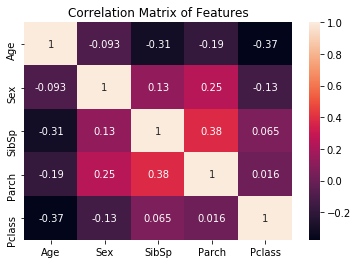

In [2423]:
# TRAINING DATA
# Correlation matrix between numerical values (Sex, SibSp, Parch, Age, Pclass values) and Survived. Fare is ignored since seems like irrelevant feature 
g = sns.heatmap(train[["Age","Sex","SibSp","Parch","Pclass"]].corr(),annot=True).set_title('Correlation Matrix of Features')

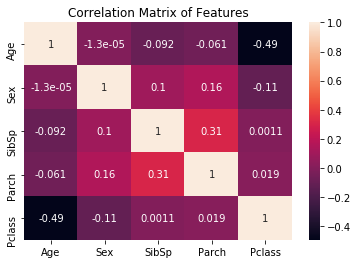

In [2424]:
# TESTING DATA
# Correlation matrix between numerical values (Sex, SibSp, Parch, Age, Pclass values) and Survived.... Fare is ignored, seems like it does not contribute to the survival probability 
g = sns.heatmap(test[["Age","Sex","SibSp","Parch","Pclass"]].corr(),annot=True).set_title('Correlation Matrix of Features')

#### Age

In [2425]:
# There are 256 missing values in Age for the whole training and testing dataset. Seen from previous.

####################################################
# Filling missing value of Age in Training Data
####################################################

## Fill Age with the median age based on Pclass, Parch and SibSp
index_NaN_age = list(train["Age"][train["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = train["Age"].median()
    age_pred = train["Age"][((train['SibSp'] == train.iloc[i]["SibSp"]) & (train['Parch'] == train.iloc[i]["Parch"]) & (train['Pclass'] == train.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        train['Age'].iloc[i] = age_pred
    else :
        train['Age'].iloc[i] = age_med

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [2426]:
####################################################
# Filling missing value of Age in Testing Data
####################################################

index_NaN_age_test = list(test["Age"][test["Age"].isnull()].index)

for i in index_NaN_age_test :
    age_med = test["Age"].median()
    age_pred = test["Age"][((test['SibSp'] == test.iloc[i]["SibSp"]) & (test['Parch'] == test.iloc[i]["Parch"]) & (test['Pclass'] == test.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        test['Age'].iloc[i] = age_pred
    else :
        test['Age'].iloc[i] = age_med

In [2427]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [2428]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,0.350738,29.300988,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,0.477472,13.389629,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,0.000000,26.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200


In [2429]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    int64  
 5   Age          881 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     881 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         0
dtype: int64

In [2430]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S


In [2431]:
test.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,0.363636,29.251603,0.447368,0.392344,35.563487
std,120.810458,0.841838,0.481622,13.055870,0.896760,0.981429,55.855686
min,892.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,0.000000,22.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,0.000000,26.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,1.000000,36.375000,1.000000,0.000000,31.471875
max,1309.000000,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200


In [2432]:
test.info()
test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 36.0+ KB


PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

#### Cabin

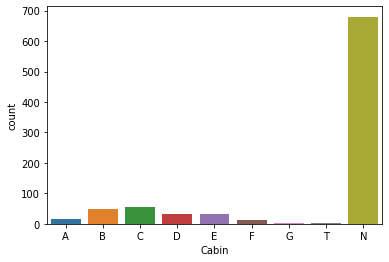

In [2433]:
# There is alot of missing Cabin values for the passenger...

# replace the missing values or null values with Cabin 'N'
train["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'N' for i in train['Cabin'] ])
g = sns.countplot(train["Cabin"],order=['A','B','C','D','E','F','G','T','N'])

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


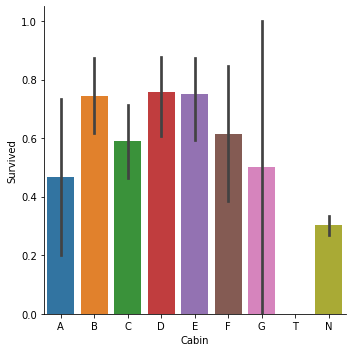

In [2434]:
# Passengers with a cabin (other than 'N') has more chance to survive
g = sns.factorplot(y="Survived",x="Cabin", data=train, kind="bar", order=['A','B','C','D','E','F','G','T','N'], size=5)

In [2435]:
# convert Cabin into intiger value
train["Cabin"] = train["Cabin"].map({"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "T": 7, "N": 8})

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


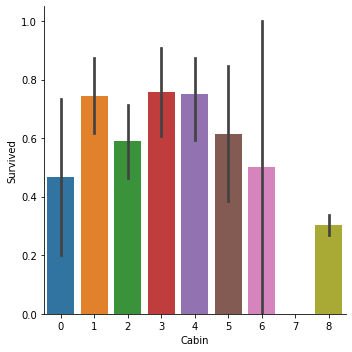

In [2436]:
g = sns.factorplot(y="Survived",x="Cabin", data=train, kind="bar", size=5)

In [2437]:
# Do same thing to testing data
test["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'N' for i in test['Cabin'] ])

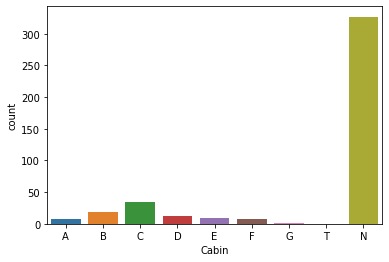

In [2438]:
g = sns.countplot(test["Cabin"],order=['A','B','C','D','E','F','G','T','N'])

In [2439]:
# convert to intigers for testing cabin data
test["Cabin"] = test["Cabin"].map({"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "T": 7, "N": 8})

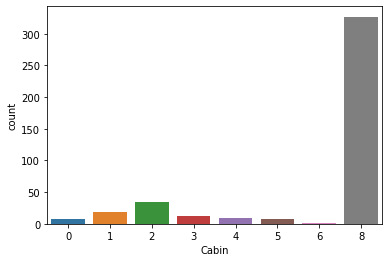

In [2440]:
g = sns.countplot(test["Cabin"])

In [2441]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,8,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,2,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,8,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,2,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,8,S


#### Embarked

In [2442]:
train["Embarked"].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

In [2443]:
# convert Embarked into integers
train["Embarked"] = train["Embarked"].map({"S": 0, "C":1, "Q": 2})

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


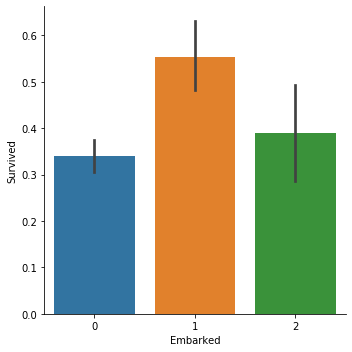

In [2444]:
g = sns.factorplot(y="Survived",x="Embarked", data=train, kind="bar", size=5)

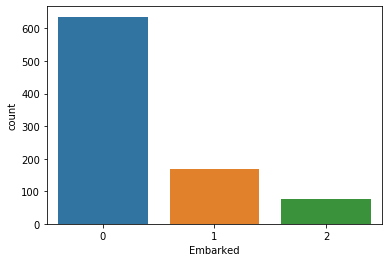

In [2445]:
g = sns.countplot(x="Embarked",data=train)

In [2446]:
test["Embarked"].describe()

count     418
unique      3
top         S
freq      270
Name: Embarked, dtype: object

In [2447]:
test["Embarked"].head()

0    Q
1    S
2    Q
3    S
4    S
Name: Embarked, dtype: object

In [2448]:
# Do same thing on testing data, convert Embarked into integer value
test["Embarked"] = test["Embarked"].map({"S": 0, "C":1, "Q": 2})

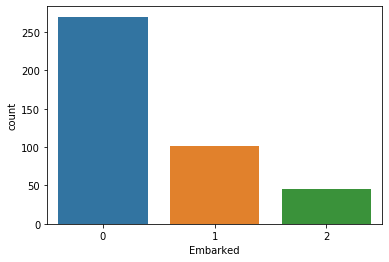

In [2449]:
g = sns.countplot(x="Embarked",data=test)

# Feature Engineering

**Note:** I didn't actually end up using the Name and Title features since they dont contribute to the model performance. After feature selection, I dropped the Name, Title, Ticket, and PassengerID irrelevant features.

#### Name

In [2450]:
train["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [2451]:
train_title = [i.split(",")[1].split(".")[0].strip() for i in train["Name"]]
train["Title"] = pd.Series(train_title)
train["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

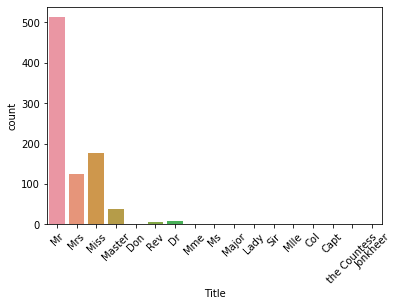

In [2452]:
g = sns.countplot(x="Title",data=train)
g = plt.setp(g.get_xticklabels(), rotation=45)

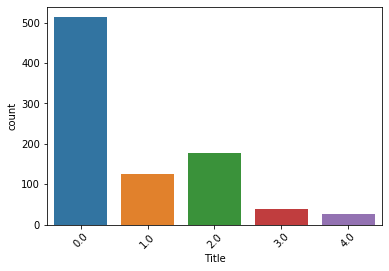

In [2453]:
# convert Title into categorical value
# category 4 is for rare titles
train["Title"] = train["Title"].map({"Mr": 0, "Mrs":1, "Miss": 2, "Master": 3, "Don": 4, "Rev": 4, "Dr": 4, "Mme": 4, "Ms": 4, "Major": 4, "Lady": 4, "Sir": 4, "Mlle": 4, "Col": 4, "Capt": 4, "the Countess": 4, "Johnkheer": 4, "the Countess Jonkheer": 4, "": 4})
g = sns.countplot(x="Title",data=train)
g = plt.setp(g.get_xticklabels(), rotation=45)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


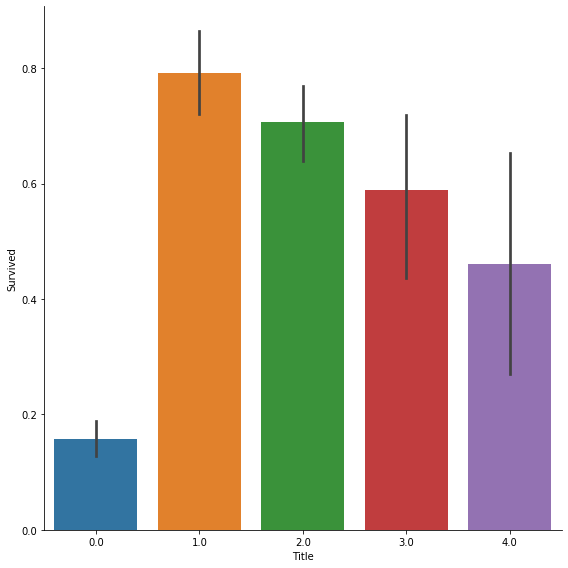

In [2454]:
g = sns.factorplot(x="Title",y="Survived",data=train,kind="bar", size = 8)

In [2455]:
# Drop Name variable
train.drop(labels = ["Name"], axis = 1, inplace = True)

In [2456]:
test["Name"].head()

0                                Kelly, Mr. James
1                Wilkes, Mrs. James (Ellen Needs)
2                       Myles, Mr. Thomas Francis
3                                Wirz, Mr. Albert
4    Hirvonen, Mrs. Alexander (Helga E Lindqvist)
Name: Name, dtype: object

In [2457]:
test_title = [i.split(",")[1].split(".")[0].strip() for i in test["Name"]]
test["Title"] = pd.Series(test_title)
test["Title"].head()

0     Mr
1    Mrs
2     Mr
3     Mr
4    Mrs
Name: Title, dtype: object

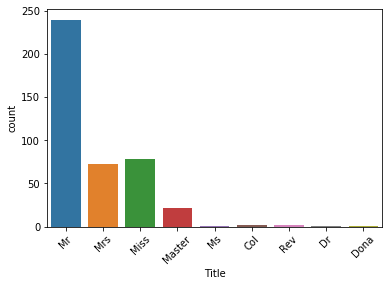

In [2458]:
g = sns.countplot(x="Title",data=test)
g = plt.setp(g.get_xticklabels(), rotation=45)

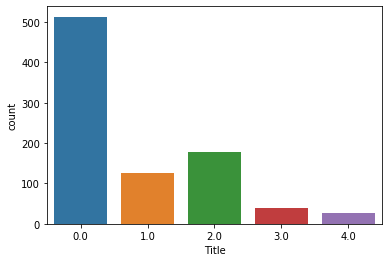

In [2459]:
test["Title"] = test["Title"].map({"Mr": 0, "Mrs":1, "Miss": 2, "Master": 3, "Don": 4, "Rev": 4, "Dr": 4, "Mme": 4, "Ms": 4, "Major": 4, "Lady": 4, "Sir": 4, "Mlle": 4, "Col": 4, "Capt": 4, "the Countess": 4, "Johnkheer": 4, "Dona":4 , "Rev":4})
g = sns.countplot(x="Title",data=train)

In [2460]:
# Drop Name variable
test.drop(labels = ["Name"], axis = 1, inplace = True)

In [2461]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,8,0,0.0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,2,1,1.0
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,8,0,2.0
3,4,1,1,1,35.0,1,0,113803,53.1000,2,0,1.0
4,5,0,3,0,35.0,0,0,373450,8.0500,8,0,0.0


In [2462]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,34.5,0,0,330911,7.8292,8,2,0
1,893,3,1,47.0,1,0,363272,7.0000,8,0,1
2,894,2,0,62.0,0,0,240276,9.6875,8,2,0
3,895,3,0,27.0,0,0,315154,8.6625,8,0,0
4,896,3,1,22.0,1,1,3101298,12.2875,8,0,1


In [2463]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,8,0,0.0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,2,1,1.0
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,8,0,2.0
3,4,1,1,1,35.0,1,0,113803,53.1000,2,0,1.0
4,5,0,3,0,35.0,0,0,373450,8.0500,8,0,0.0


In [2464]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,34.5,0,0,330911,7.8292,8,2,0
1,893,3,1,47.0,1,0,363272,7.0000,8,0,1
2,894,2,0,62.0,0,0,240276,9.6875,8,2,0
3,895,3,0,27.0,0,0,315154,8.6625,8,0,0
4,896,3,1,22.0,1,1,3101298,12.2875,8,0,1


#### Pclass

In [2465]:
# Create categorical values for Pclass
train["Pclass"] = train["Pclass"].astype("category")
train = pd.get_dummies(train, columns = ["Pclass"],prefix="Pc")

In [2466]:
# Create categorical values for Pclass
test["Pclass"] = test["Pclass"].astype("category")
test = pd.get_dummies(test, columns = ["Pclass"],prefix="Pc")

#### Drop Useless Feature Variables

In [2467]:
train.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pc_1,Pc_2,Pc_3
0,1,0,0,22.0,1,0,A/5 21171,7.2500,8,0,0.0,0,0,1
1,2,1,1,38.0,1,0,PC 17599,71.2833,2,1,1.0,1,0,0
2,3,1,1,26.0,0,0,STON/O2. 3101282,7.9250,8,0,2.0,0,0,1
3,4,1,1,35.0,1,0,113803,53.1000,2,0,1.0,1,0,0
4,5,0,0,35.0,0,0,373450,8.0500,8,0,0.0,0,0,1


In [2468]:
train.drop(labels = ["PassengerId"], axis = 1, inplace = True)
train.head()

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pc_1,Pc_2,Pc_3
0,0,0,22.0,1,0,A/5 21171,7.2500,8,0,0.0,0,0,1
1,1,1,38.0,1,0,PC 17599,71.2833,2,1,1.0,1,0,0
2,1,1,26.0,0,0,STON/O2. 3101282,7.9250,8,0,2.0,0,0,1
3,1,1,35.0,1,0,113803,53.1000,2,0,1.0,1,0,0
4,0,0,35.0,0,0,373450,8.0500,8,0,0.0,0,0,1


In [2469]:
train.drop(labels = ["Title"], axis = 1, inplace = True)
train.drop(labels = ["Ticket"], axis = 1, inplace = True)

train.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Pc_1,Pc_2,Pc_3
0,0,0,22.0,1,0,7.2500,8,0,0,0,1
1,1,1,38.0,1,0,71.2833,2,1,1,0,0
2,1,1,26.0,0,0,7.9250,8,0,0,0,1
3,1,1,35.0,1,0,53.1000,2,0,1,0,0
4,0,0,35.0,0,0,8.0500,8,0,0,0,1


In [2471]:
test.head()

,PassengerId,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pc_1,Pc_2,Pc_3
0,892,0,34.5,0,0,330911,7.8292,8,2,0,0,0,1
1,893,1,47.0,1,0,363272,7.0000,8,0,1,0,0,1
2,894,0,62.0,0,0,240276,9.6875,8,2,0,0,1,0
3,895,0,27.0,0,0,315154,8.6625,8,0,0,0,0,1
4,896,1,22.0,1,1,3101298,12.2875,8,0,1,0,0,1


In [2472]:
test.drop(labels = ["PassengerId"], axis = 1, inplace = True)
test.head()

,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pc_1,Pc_2,Pc_3
0,0,34.5,0,0,330911,7.8292,8,2,0,0,0,1
1,1,47.0,1,0,363272,7.0000,8,0,1,0,0,1
2,0,62.0,0,0,240276,9.6875,8,2,0,0,1,0
3,0,27.0,0,0,315154,8.6625,8,0,0,0,0,1
4,1,22.0,1,1,3101298,12.2875,8,0,1,0,0,1


In [2473]:
test.drop(labels = ["Title"], axis = 1, inplace = True)
test.drop(labels = ["Ticket"], axis = 1, inplace = True)
test.head()

,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Pc_1,Pc_2,Pc_3
0,0,34.5,0,0,7.8292,8,2,0,0,1
1,1,47.0,1,0,7.0000,8,0,0,0,1
2,0,62.0,0,0,9.6875,8,2,0,1,0
3,0,27.0,0,0,8.6625,8,0,0,0,1
4,1,22.0,1,1,12.2875,8,0,0,0,1


# Modeling


In [2475]:
train["Survived"] = train["Survived"].astype(int)

X = train.drop(labels = ["Survived"], axis=1) #features
Y = train.Survived #labels

In [2476]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=101)

In [2477]:
# fill empty and NaNs values in testing data with NaN
test = test.fillna(np.nan)
test.info()
test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex       418 non-null    int64  
 1   Age       418 non-null    float64
 2   SibSp     418 non-null    int64  
 3   Parch     418 non-null    int64  
 4   Fare      418 non-null    float64
 5   Cabin     418 non-null    int64  
 6   Embarked  418 non-null    int64  
 7   Pc_1      418 non-null    uint8  
 8   Pc_2      418 non-null    uint8  
 9   Pc_3      418 non-null    uint8  
dtypes: float64(2), int64(5), uint8(3)
memory usage: 24.2 KB


Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
Pc_1        0
Pc_2        0
Pc_3        0
dtype: int64

In [2478]:
# fill empty and NaNs values in testing data with NaN
train = train.fillna(np.nan)
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  881 non-null    int64  
 1   Sex       881 non-null    int64  
 2   Age       881 non-null    float64
 3   SibSp     881 non-null    int64  
 4   Parch     881 non-null    int64  
 5   Fare      881 non-null    float64
 6   Cabin     881 non-null    int64  
 7   Embarked  881 non-null    int64  
 8   Pc_1      881 non-null    uint8  
 9   Pc_2      881 non-null    uint8  
 10  Pc_3      881 non-null    uint8  
dtypes: float64(2), int64(6), uint8(3)
memory usage: 57.8 KB


Survived    0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
Pc_1        0
Pc_2        0
Pc_3        0
dtype: int64

In [2479]:
steps = [('scaller', MinMaxScaler()),
         ('clf', RandomForestClassifier())]

predictor = Pipeline(steps)
predictor.fit(x_train, y_train)

print(predictor.score(x_train, y_train))
print(accuracy_score(predictor.predict(x_test), y_test))
print(confusion_matrix(predictor.predict(x_test), y_test))
print(classification_report(predictor.predict(x_test), y_test))

0.9878787878787879
0.7782805429864253
[[107  27]
 [ 22  65]]
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       134
           1       0.71      0.75      0.73        87

    accuracy                           0.78       221
   macro avg       0.77      0.77      0.77       221
weighted avg       0.78      0.78      0.78       221



In [2481]:
len(x_train)

660

In [2482]:
len(y_train)

660

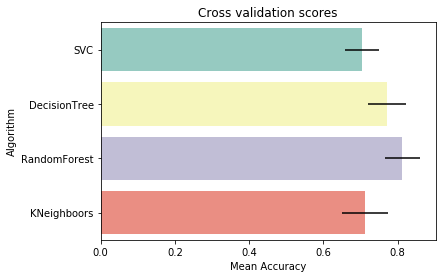

In [2483]:
##################################
# Modeling step Test differents algorithms 
# Cross validate model with Kfold stratified cross validation
##################################
kfold = StratifiedKFold(n_splits=10) 
classifiers = []
random_state = 2
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, x_train, y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","RandomForest","KNeighboors"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g = g.set_title("Cross validation scores")
g.set_xlabel("Mean Accuracy")

In [2484]:
##################################
# SVC classifier
##################################
SVMC = SVC(probability=True)
svc_param_grid = {"kernel": ['rbf'], 
                  "gamma": [ 0.001, 0.01, 0.1, 1],
                  "C": [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsSVMC.fit(x_train,y_train)
SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   26.1s finished


0.8045454545454545

In [2485]:
##################################
# Decision Tree classifier
##################################
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "algorithm" : ["SAMME","SAMME.R"],
                  "n_estimators" :[1,2],
                  "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(x_train,y_train)
ada_best = gsadaDTC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    6.1s finished


0.8045454545454545

In [2519]:
ada_best

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                    

In [2486]:
##################################
# Random Forest classifier
##################################

RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [False],
                  "n_estimators" :[100,300],
                  "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsRFC.fit(x_train,y_train)
RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.6min finished


0.8303030303030303

In [2487]:
##################################
# KNN classifier
##################################
KNN = KNeighborsClassifier()

rf_param_grid = {"n_neighbors": [1,2,3,5,11,19],
                "weights": ['uniform', 'distance'],
                "metric": ['euclidean','manhattan']}

gsKNN = GridSearchCV(KNN,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsKNN.fit(x_train,y_train)

KNN_best = gsKNN.best_estimator_

# Best score
gsKNN.best_score_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 191 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:    1.2s finished


0.7621212121212121

#### Plot Learning Curves

In [2488]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


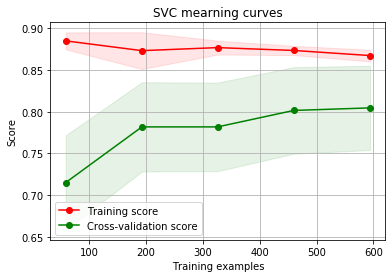

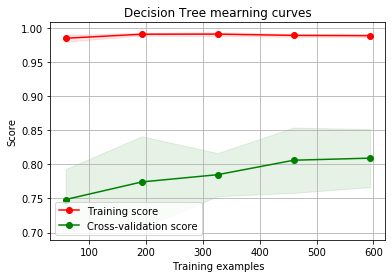

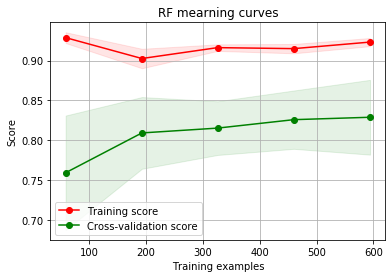

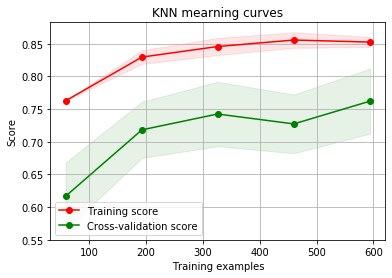

In [2489]:
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC mearning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"Decision Tree mearning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsKNN.best_estimator_,"KNN mearning curves",x_train,y_train,cv=kfold)

From the plots above, you can tell that Decision tree tends to overfit the model. The training score is very high and the cross validation score is low. 

# Prediction

In [2490]:
def get_scores(predictor, x_train, y_train):
    print(predictor, ":")
    print()
    print("training: ", predictor.score(x_train, y_train))
    print("testing: ", accuracy_score(predictor.predict(x_test), y_test))
    print()
    print("confusion matrix:")
    print(confusion_matrix(predictor.predict(x_test), y_test))

    print()
    print("classification report:")
    print(classification_report(predictor.predict(x_test), y_test))
    print("-----------------------------------------------------------")


In [2491]:
def get_cm(predictor, x_test, y_test):
    return pd.DataFrame(confusion_matrix(predictor.predict(x_test), y_test), columns=['Predict 0', 'Predict 1'], index=['Actual 0', 'Actual 1'])

In [2492]:
get_scores(gsSVMC.best_estimator_, x_train, y_train)
get_scores(gsadaDTC.best_estimator_, x_train, y_train)
get_scores(gsRFC.best_estimator_, x_train, y_train)
get_scores(gsKNN.best_estimator_, x_train, y_train)

SVC(C=200, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False) :

training:  0.8636363636363636
testing:  0.7647058823529411

confusion matrix:
[[100  23]
 [ 29  69]]

classification report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       123
           1       0.75      0.70      0.73        98

    accuracy                           0.76       221
   macro avg       0.76      0.76      0.76       221
weighted avg       0.76      0.76      0.76       221

-----------------------------------------------------------
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                  

In [2493]:
get_cm(gsSVMC.best_estimator_, x_test, y_test)

,Predict 0,Predict 1
Actual 0,100,23
Actual 1,29,69


In [2494]:
# DECISION TREE has the highest score
get_cm(gsadaDTC.best_estimator_, x_test, y_test)


,Predict 0,Predict 1
Actual 0,110,25
Actual 1,19,67


In [2495]:
get_cm(gsRFC.best_estimator_, x_test, y_test)

,Predict 0,Predict 1
Actual 0,108,28
Actual 1,21,64


In [2496]:
get_cm(gsKNN.best_estimator_, x_test, y_test)

,Predict 0,Predict 1
Actual 0,102,30
Actual 1,27,62


In [2497]:
x_train.head()

,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Pc_1,Pc_2,Pc_3
448,0,29.0,0,0,7.8958,8,1,0,0,1
530,1,30.0,0,0,106.4250,8,1,1,0,0
753,0,26.0,0,0,14.5000,8,0,0,0,1
878,1,13.5,1,2,23.4500,8,0,0,0,1
699,1,45.0,0,0,13.5000,8,0,0,1,0


In [2498]:
test.head()

,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Pc_1,Pc_2,Pc_3
0,0,34.5,0,0,7.8292,8,2,0,0,1
1,1,47.0,1,0,7.0000,8,0,0,0,1
2,0,62.0,0,0,9.6875,8,2,0,1,0
3,0,27.0,0,0,8.6625,8,0,0,0,1
4,1,22.0,1,1,12.2875,8,0,0,0,1


In [2499]:
#######################
# Prediction for Kaggle Submission
#######################
final_predictor = gsadaDTC.best_estimator_
test_Survived = pd.Series(final_predictor.predict(test), name="Survived")
results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("prediction_result.csv",index=False)


# Deployment

#### Load Data to S3

In [2527]:
###### NEED TO GET PROCESSED TRAINING DATA LOADED TO S3
train.describe()

,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Pc_1,Pc_2,Pc_3
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,0.385925,0.350738,29.300988,0.455165,0.363224,31.121566,6.721907,0.365494,0.241771,0.208854,0.549376
std,0.487090,0.477472,13.389629,0.871571,0.791839,47.996249,2.456639,0.638100,0.428399,0.406720,0.497839
min,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,22.000000,0.000000,0.000000,7.895800,8.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,26.000000,0.000000,0.000000,14.454200,8.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,36.000000,1.000000,0.000000,30.500000,8.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,80.000000,5.000000,6.000000,512.329200,8.000000,2.000000,1.000000,1.000000,1.000000


In [2528]:
training = pd.concat([train],axis=1)
training.to_csv("training.csv",index=False)

In [2529]:
import pandas as pd
import boto3
import sagemaker

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

In [2530]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [2532]:
# should be the name of directory you created to save your features data
data_dir = 'training.csv'

# set prefix, a descriptive name for a directory  
prefix = 'passenger_data_s3'

# upload all data to S3
training_file_location = sagemaker_session.upload_data(data_dir, bucket, prefix)
print(training_file_location)

s3://sagemaker-us-east-1-675691040096/passenger_data_s3/training.csv


In [2533]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

passenger_data/
passenger_data/test.csv
passenger_data/train.csv
passenger_data/training.csv
passenger_data_s3/test.csv
passenger_data_s3/train.csv
passenger_data_s3/training.csv
sagemaker-scikit-learn-2021-01-11-23-14-33-153/profiler-output/system/incremental/2021011123/1610407020.algo-1.json
sagemaker-scikit-learn-2021-01-11-23-14-33-153/source/sourcedir.tar.gz
sagemaker-scikit-learn-2021-01-11-23-19-43-004/profiler-output/system/incremental/2021011123/1610407320.algo-1.json
sagemaker-scikit-learn-2021-01-11-23-19-43-004/source/sourcedir.tar.gz
sagemaker-scikit-learn-2021-01-11-23-26-22-983/profiler-output/system/incremental/2021011123/1610407680.algo-1.json
sagemaker-scikit-learn-2021-01-11-23-26-22-983/profiler-output/system/incremental/2021011123/1610407740.algo-1.json
sagemaker-scikit-learn-2021-01-11-23-26-22-983/source/sourcedir.tar.gz
Test passed!


#### Complete training script

In [2538]:
# directory can be changed to: source_sklearn or source_pytorch
!pygmentize source_sklearn/train.py

from __future__ import print_function

import argparse
import os
import pandas as pd

# sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. 
# from sklearn.externals import joblib
# Import joblib package directly
#import joblib
from sklearn.externals import joblib


## TODO: Import any additional libraries you need to define a model
from sklearn.linear_model import LinearRegression

# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model


## TODO: Complete the main code
if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument pa

#### Create Scikit-learn Estimator

In [2539]:
from sagemaker.sklearn.estimator import SKLearn

In [2540]:
estimator = SKLearn(entry_point='train.py',
                    framework_version='0.20.0',
                    py_version='py3',
                    source_dir='source_sklearn',
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.m5.xlarge',
                   )

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [2544]:
%%time
estimator.fit({'train': training_file_location})


#### Deploy the trained model

In [2545]:
%%time

# uncomment, if needed
# from sagemaker.pytorch import PyTorchModel

# deploy your model to create a predictor
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')


#### Determine Accuracy of model

In [2546]:
# First: generate predicted, class labels
test_y_preds = predictor.predict(test)


In [2547]:
#######################
# Prediction for Kaggle
#######################
# final_predictor = gsadaDTC.best_estimator_
test_Survived = pd.Series(test_y_preds, name="Survived")
results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("deployed_prediction_result.csv",index=False)


#### Clean Up Resources

In [2549]:
# uncomment and fill in the line below!
# <name_of_deployed_predictor>.delete_endpoint()
predictor.delete_endpoint()

In [2550]:
# deleting bucket, uncomment lines below
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '2P2HBYFR0Y2P8V7R',
   'HostId': 'a444m+qVN1Hy8BdOizOj8muhTfs6+W6L7z5N542tNLHm+Ah9EU8OHW4eKU6dkwI3bMdPI2denZY=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'a444m+qVN1Hy8BdOizOj8muhTfs6+W6L7z5N542tNLHm+Ah9EU8OHW4eKU6dkwI3bMdPI2denZY=',
    'x-amz-request-id': '2P2HBYFR0Y2P8V7R',
    'date': 'Mon, 11 Jan 2021 23:51:16 GMT',
    'connection': 'close',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'passenger_data/test.csv'},
   {'Key': 'passenger_data/'},
   {'Key': 'sagemaker-scikit-learn-2021-01-11-23-40-08-679/source/sourcedir.tar.gz'},
   {'Key': 'sagemaker-scikit-learn-2021-01-11-23-14-33-153/profiler-output/system/incremental/2021011123/1610407020.algo-1.json'},
   {'Key': 'sagemaker-scikit-learn-2021-01-11-23-19-43-004/profiler-output/system/incremental/2021011123/1610407320.algo-1.json'},
   {'Key': 'sagemaker-scikit-learn-2021-0